# Notebook for Clustering

This notebook focuses on the clustering of financial market states using the Louvain method. Starting with the log-return matrix constructed earlier, we apply the Louvain clustering algorithm to identify distinct market regimes. This structured approach provides insights into how market conditions evolve over time and allows for segmentation into meaningful states for further analysis.

Let's start by importing the necessary libraries. Key libraries include :
- `adjusted_rand_score`: To measure the similarity between two partitions (or clusters) of a data set
- `community_louvain`: A simple method to extract the community structure of a network.
- `eig`: To compute the eigenvalues and eigenvectors of general square arrays.
- `matplotlib`: For creating clear graphs that will be used to analyze the results.
- `networkx`: For the creation, manipulation, and study of the structure, dynamics, and functions of complex networks.
- `numpy` and `pandas`: For numerical calculations and efficient DataFrame manipulations.
- `pickle`: For serializing and de-serializing a Python object structure.

In [ ]:
# Import necessary libraries

from sklearn.metrics import adjusted_rand_score
from community import community_louvain
from numpy.linalg import eig

import matplotlib.pyplot as plt
import networkx as nx
import pandas as pd
import numpy as np

import pickle

We start by loading the log-return matrix from a CSV file. Each row represents a time window, and each column representsa financial asset (ticker). The matrix contains log-returns for a 5-minute window period.

In [ ]:
# Load the log return matrix
log_return_matrix = pd.read_csv('log_return_matrix.csv')

The following function performs clustering on non-overlapping sliding windows within the log-return matrix. For each window, it computes a filtered correlation matrix, applies the Louvain clustering algorithm, and maps clusters to timestamps. The eigenvalue filtering ensures that only significant correlations are considered.

In [ ]:
def sliding_window_clustering_no_overlap(matrix, window_size):
    """
    Perform clustering on completely non-overlapping windows with minimal progress updates.

    Parameters:
    - matrix (pd.DataFrame): The log return matrix with a 'timestamp' column and stock returns as other columns.
    - window_size (int): The size of the window in minutes.

    Returns:
    - results (list of dict): A list where each element contains the clustering result for a window.
                              Each element is a dictionary with 'start_time', 'end_time',
                              'num_clusters', 'clusters_df', and 'ari_score' (compared to the previous window).
    """
    # Start by making sure the timestamp is in datetime format
    matrix['timestamp_5min'] = pd.to_datetime(matrix['timestamp_5min'], utc=True)
    results = []  # To store clustering results for each window
    num_rows = matrix.shape[0]
    total_windows = num_rows // window_size  # Total number of full windows

    print(f"Starting clustering for {total_windows} non-overlapping windows (window size: {window_size})...\n")
    previous_labels = None  # To store the cluster labels of the previous window
    
    for window_num, start in enumerate(range(0, num_rows, window_size), start=1):
        end = start + window_size
        if end > num_rows:  # Skip the last window if it doesn't fit the size
            break
        
        print(f"Processing window {window_num} / {total_windows}...")

        # Define the current window
        matrix_window = matrix.iloc[start:end]
        timestamps = matrix_window['timestamp_5min']
        matrix_window_numeric = matrix_window.drop(columns=['timestamp_5min'])

        # Compute the correlation matrix for time periods
        C = matrix_window_numeric.T.corr()
        eigvals, eigvecs = eig(C)

        # Retain significant eigenvalues
        threshold = 0.035 * sum(eigvals)
        filtered_eigvals = [val if val >= threshold else 0 for val in eigvals]

        # Reconstruct filtered correlation matrix
        C_filtered = eigvecs @ np.diag(filtered_eigvals) @ eigvecs.T

        # Convert to a graph and apply Louvain clustering
        C_graph = np.abs(C_filtered)
        graph = nx.from_numpy_array(C_graph)
        partition = community_louvain.best_partition(graph)
        num_clusters = len(set(partition.values()))
        
        # Map time periods to clusters
        clusters_df = pd.DataFrame({
            'Timestamp': timestamps,
            'Cluster': [partition[i] for i in range(len(matrix_window))]
        })
        
        # Compute ARI if this is not the first window
        current_labels = clusters_df['Cluster'].values
        ari_score = None
        if previous_labels is not None:
            ari_score = adjusted_rand_score(previous_labels, current_labels)
        
        # Store the result
        results.append({
            'start_time': timestamps.iloc[0],
            'end_time': timestamps.iloc[-1],
            'num_clusters': num_clusters,
            'clusters_df': clusters_df,
            'ari_score': ari_score  # ARI compared to the previous window
        })
        
        # Update the previous labels
        previous_labels = current_labels
    
    print("\nClustering completed for all windows!")
    
    return results

Now, we execute the clustering function for a chosen window size and save the results as a CSV file on the desktop for future analysis.

In [ ]:
window_size = 100  # Size of each window
clustering_results = sliding_window_clustering_no_overlap(log_return_matrix, window_size)

Let's visualize the number of clusters detected across all windows, providing insight into clustering stability and variance over time.

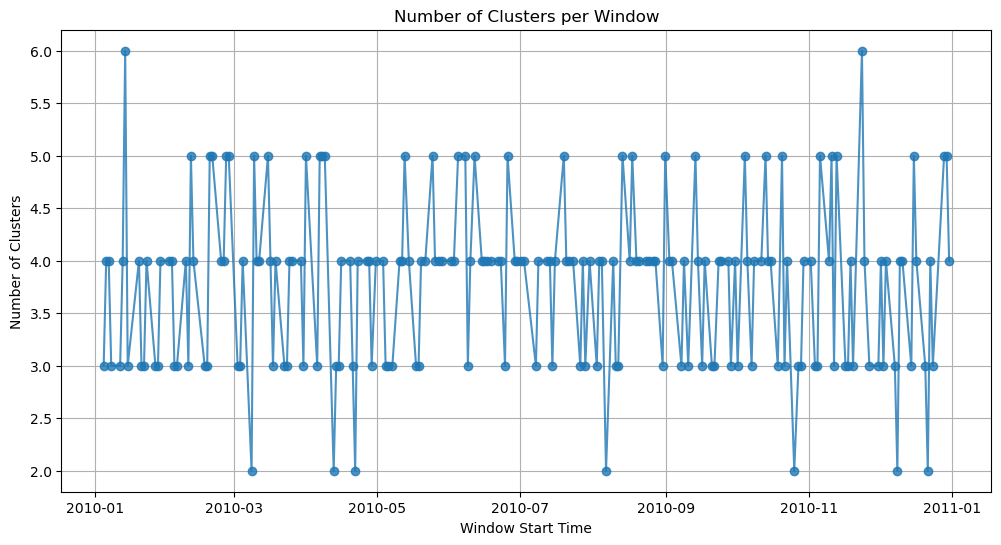

In [16]:
def plot_num_clusters_per_window(results):
    """
    Plot the number of clusters detected for each window.
    
    Parameters:
    - results (list of dict): Output of the sliding_window_clustering function.
    """
    # Extract the number of clusters and window start times
    num_clusters = [res['num_clusters'] for res in results]
    window_start_times = [res['start_time'] for res in results]
    
    plt.figure(figsize=(12, 6))
    plt.plot(window_start_times, num_clusters, marker='o', linestyle='-', alpha=0.8)
    plt.xlabel("Window Start Time")
    plt.ylabel("Number of Clusters")
    plt.title("Number of Clusters per Window")
    plt.grid(True)
    plt.show()

# Plot the number of clusters detected for each window
plot_num_clusters_per_window(clustering_results)

To understand the general clustering behavior, we calculate the mean number of clusters detected across all time windows.

In [19]:
# Calculate the mean number of clusters
mean_clusters = np.mean([res['num_clusters'] for res in clustering_results])
print(f"Mean number of clusters across all windows : {mean_clusters:.2f}")

Mean number of clusters across all windows : 3.78


The `results` object is saved as a pickle file for future use in strategy implementation. The saved results
can be loaded in another notebook, such as the strategy notebook, to design trading strategies based on market states.

In [ ]:
# Save clustering results for future use
results_pickle_file = "clustering_results.pkl"

with open(results_pickle_file, "wb") as file:
    pickle.dump(clustering_results, file)

To evaluate the similarity between clusters in consecutive clustering windows, we computed the Adjusted Rand Index (ARI) and plotted its distribution as a histogram.

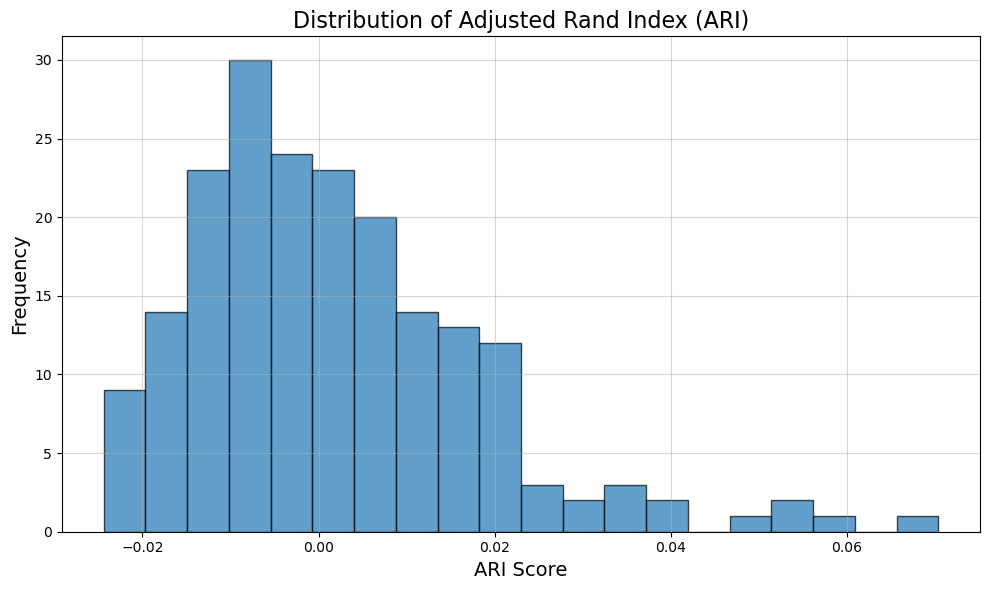

In [27]:
def plot_ari_distribution(results, bins):
    """
    Plot a histogram of the Adjusted Rand Index (ARI) distribution.

    Parameters:
    - results (list of dict): The clustering results from the sliding_window_clustering_with_ARI function.
                              Each element must contain 'ari_score'.
    - bins (int): The number of bins for the histogram. Default is 10.
    """
    # Extract ARI scores, excluding None values
    ari_scores = [result['ari_score'] for result in results if result['ari_score'] is not None]

    # Plot histogram
    plt.figure(figsize=(10, 6))
    plt.hist(ari_scores, bins=bins, alpha=0.7, edgecolor='black')
    plt.title('Distribution of Adjusted Rand Index (ARI)', fontsize=16)
    plt.xlabel('ARI Score', fontsize=14)
    plt.ylabel('Frequency', fontsize=14)
    plt.grid(alpha=0.5)
    plt.tight_layout()
    plt.show()

plot_ari_distribution(clustering_results, bins=20)

The ARI scores are primarily distributed around 0, indicating minimal similarity between clusters in consecutive clustering windows. This suggests that market states are not stationary. Therefore, this notebook has successfully implemented a clustering framework using the Louvain method. We structured our dataset into non-overlapping sliding windows, calculated filtered correlation matrices, and detected distinct market states. The clustering results are saved for further analysis, setting the stage for exploring market dynamics.